# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

06:56:02 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=896300;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=842914;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=813032;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=330404;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

06:56:53 INFO      Auto-determined polynomial order: 0                                ]8;id=16606;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=791811;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

06:57:12 INFO      None 0-order polynomial fit with the mle method                               ]8;id=973866;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=912932;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=759968;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=229619;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=839218;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=366619;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=560692;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=421672;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=740397;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=806043;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

06:57:13 INFO      Auto-probed noise models:                                                    ]8;id=74804;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=762119;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=939734;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=155018;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=198303;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=49712;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=392126;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=86362;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

06:57:16 INFO      Now using 120 bins                                                          ]8;id=589496;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=76607;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

06:57:19 INFO      Auto-determined polynomial order: 1                                ]8;id=449475;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=976143;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

06:57:38 INFO      None 1-order polynomial fit with the mle method                               ]8;id=524285;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=110828;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=73876;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=938603;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=364501;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=459498;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=369526;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=150258;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=749211;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=661246;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

06:57:39 INFO      Auto-probed noise models:                                                    ]8;id=346084;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=322174;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=625982;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=423550;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=465986;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=939988;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=618373;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=766029;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=280505;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=525163;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

06:57:42 INFO      Auto-determined polynomial order: 1                                ]8;id=988792;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=674265;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

06:58:01 INFO      None 1-order polynomial fit with the mle method                               ]8;id=887679;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=258198;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=113929;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=738327;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=289405;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=26687;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

06:58:02 INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=814869;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=600993;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=507680;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=962452;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=123233;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=459969;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#469\469]8;;\

         INFO      - observation: poisson                                                       ]8;id=164585;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=475087;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#470\470]8;;\

         INFO      - background: gaussian                                                       ]8;id=376735;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=730573;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#471\471]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=411695;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=584760;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=484718;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=563220;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

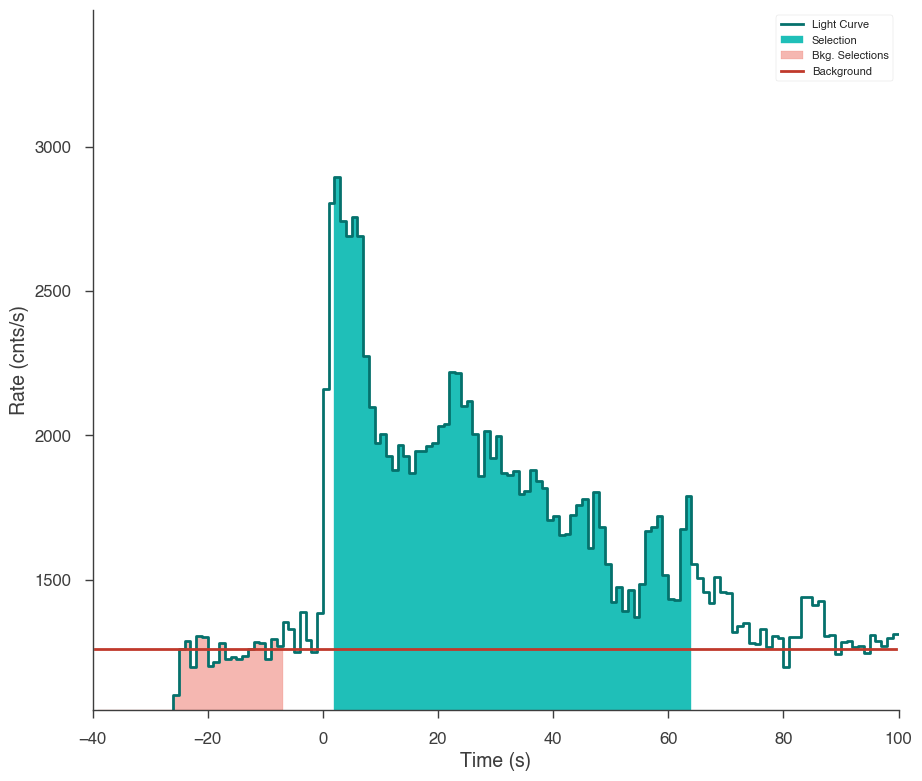

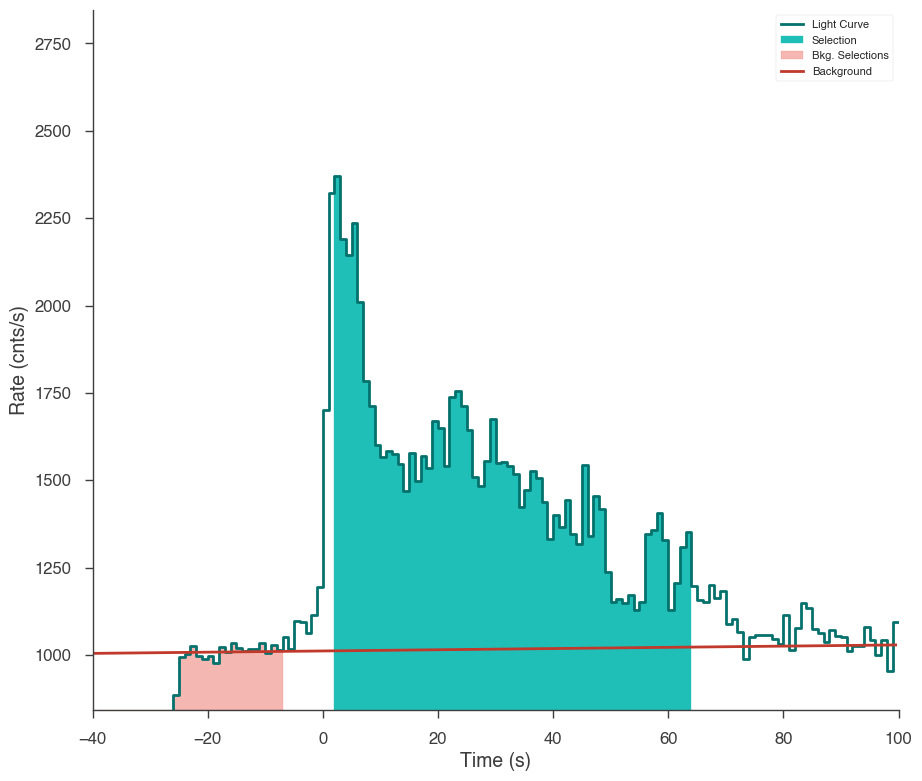

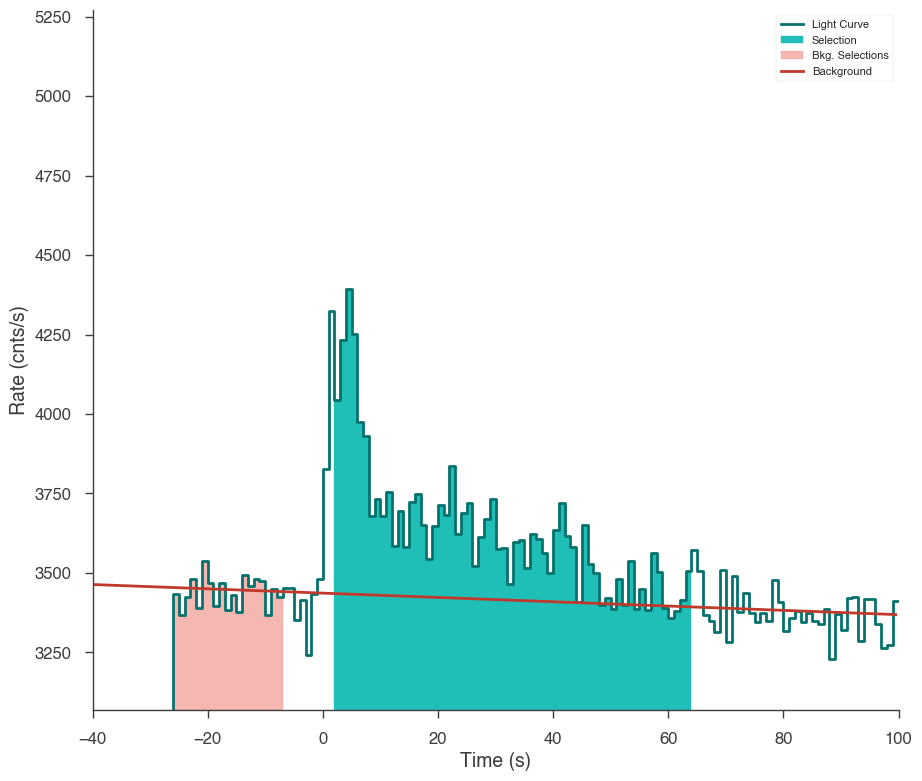

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

06:58:03 INFO      sampler set to multinest                                                ]8;id=939443;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=104363;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

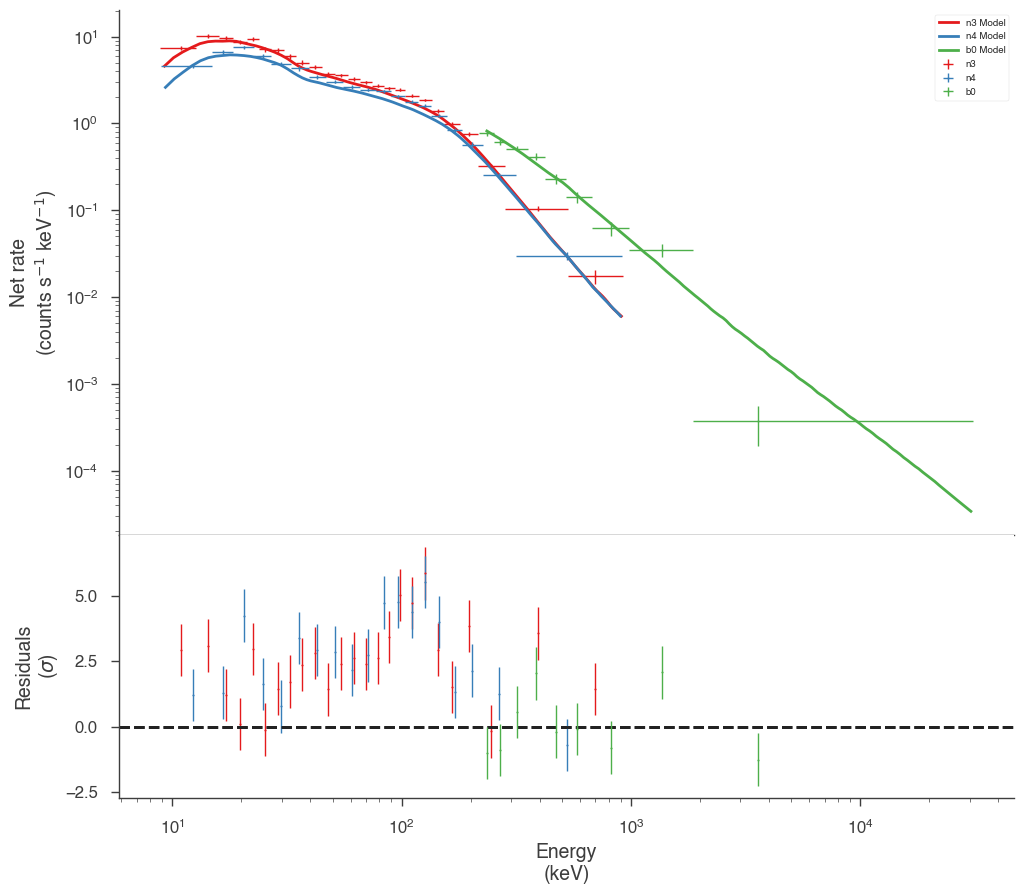

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


 ln(ev)=  -3101.3668058375379      +/-  0.22478548251245750     
 Total Likelihood Evaluations:        25793
  analysing data from chains/fit-.txt
 Sampling finished. Exiting MultiNest


06:58:29 INFO      fit restored to maximum of posterior                                         ]8;id=632913;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=828473;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=283427;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=39841;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
GRB080916009...K,(1.464 -0.013 +0.024) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.0937 -0.0009 +0.035,
GRB080916009...break_energy,(1.89 +0.09 +0.7) x 10^2,keV
GRB080916009...break_scale,(0.0 +1.5 +3.2) x 10^-1,
GRB080916009...beta,-1.971 -0.21 -0.028,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0,-1049.693957
n3,-1019.240073
n4,-1010.343735
total,-3079.277765


Values of statistical measures:

,statistical measures
AIC,6168.725985
BIC,6187.958195
DIC,6179.629984
PDIC,4.280406
log(Z),-1346.906490


Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=463877;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=564284;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

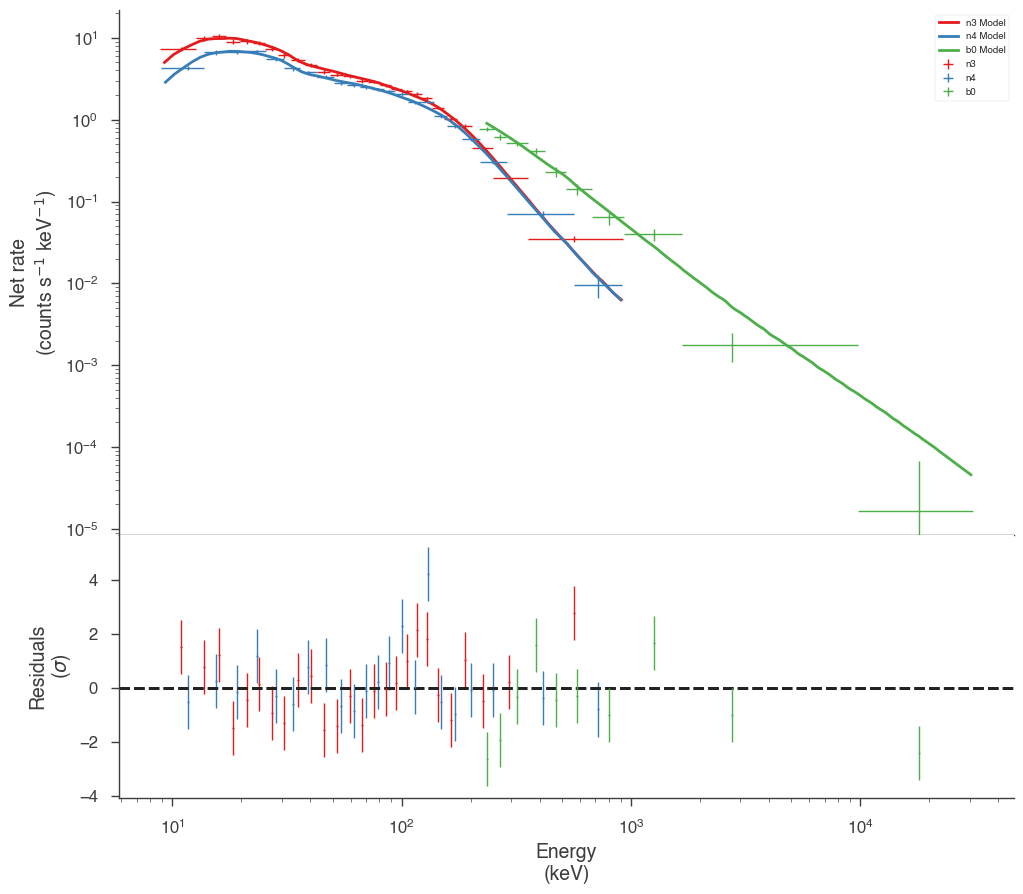

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

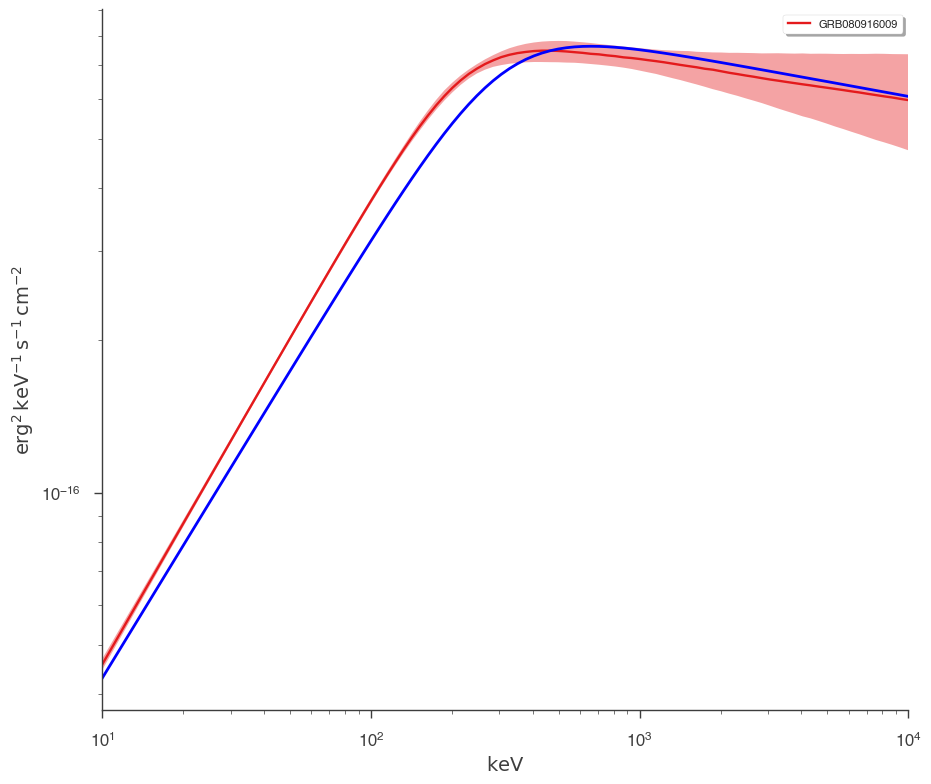

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

07:00:33 INFO      Created 15 bins via bayesblocks                                       ]8;id=485724;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=474753;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


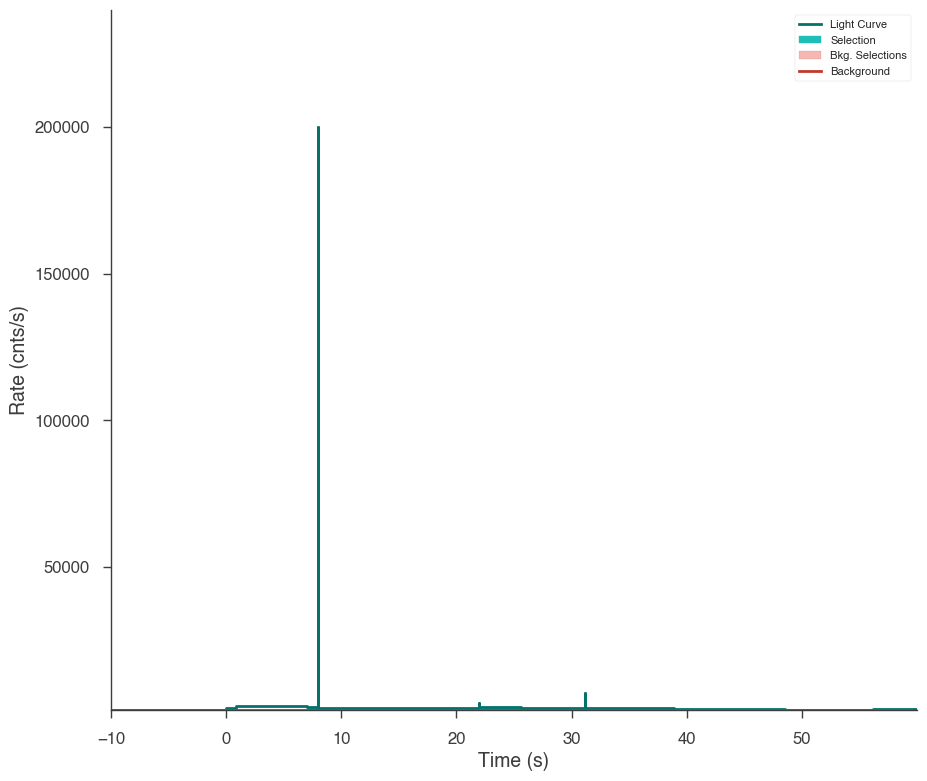

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

07:00:34 INFO      Created 12 bins via custom                                            ]8;id=560598;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=352878;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

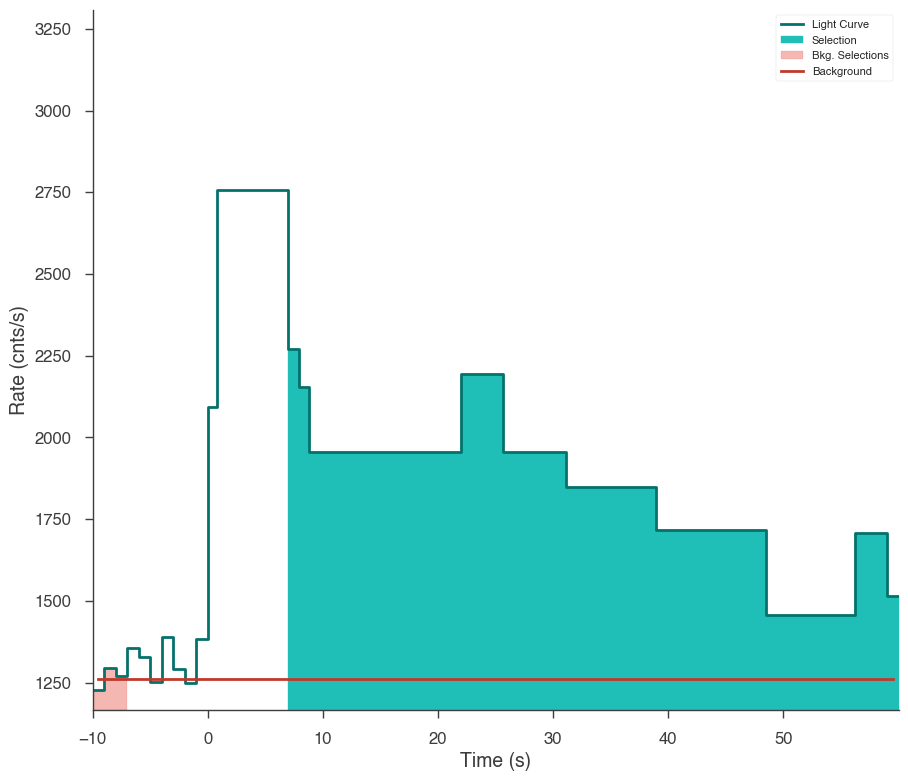

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=28963;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=465776;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

07:00:35 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=868173;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=279988;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=643009;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=173981;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=83025;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=308552;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=616339;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=388271;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

07:00:36 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=212306;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=646123;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=686073;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=394842;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=743531;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=715801;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=347588;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=269658;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=850696;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=789698;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=239833;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=968776;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 107 bins                                                          ]8;id=632432;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=294848;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=764179;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=397703;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -788.45156947631699      +/-  0.17673020623425439     
 Total Likelihood Evaluations:        16357
 Sampling finished. Exiting MultiNest



07:00:53 INFO      fit restored to maximum of posterior                                         ]8;id=525397;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=389717;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=768471;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=18462;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.7 -0.7 +0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.4 -1.6 +1.1) x 10^-1,
grb.spectrum.main.Band.xp,(3.01 -0.34 +1.0) x 10^2,keV
grb.spectrum.main.Band.beta,-2.01 -0.5 +0.06,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval0,-285.632679
n3_interval0,-250.030941
n4_interval0,-267.906879
total,-803.570499


Values of statistical measures:

,statistical measures
AIC,1615.254312
BIC,1630.663129
DIC,1570.596503
PDIC,2.256817
log(Z),-342.420166


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=325056;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=223395;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=966803;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=365137;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=104671;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=935325;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=283482;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=454765;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=903909;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=371106;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=522822;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=316514;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=969343;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=446435;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1998.5189256130209      +/-  0.22306097454545898     
 Total Likelihood Evaluations:        23793
 Sampling finished. Exiting MultiNest



07:01:18 INFO      fit restored to maximum of posterior                                         ]8;id=455845;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=203236;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=771467;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=878067;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(5.26 -0.16 +0.21) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.60 -0.4 +0.31) x 10^-1,
grb.spectrum.main.Band.xp,(4.13 -0.30 +0.14) x 10^2,keV
grb.spectrum.main.Band.beta,-2.324 +0.009 +0.11,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval1,-693.806258
n3_interval1,-660.516221
n4_interval1,-654.049335
total,-2008.371814


Values of statistical measures:

,statistical measures
AIC,4024.856942
BIC,4040.265759
DIC,3971.847167
PDIC,-0.054349
log(Z),-867.945741


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=824261;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=684930;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=13352;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=779709;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=141187;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=768882;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=912761;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=835416;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=201797;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=99445;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 115 bins                                                          ]8;id=57369;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=823259;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=908504;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=511868;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -906.69631560468645      +/-  0.19063314066475726     
 Total Likelihood Evaluations:        20291
 Sampling finished. Exiting MultiNest



07:01:38 INFO      fit restored to maximum of posterior                                         ]8;id=85776;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=627700;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

07:01:39 INFO      fit restored to maximum of posterior                                         ]8;id=960980;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=951147;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.57 -0.11 +0.34) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.03 -0.06 +0.07,
grb.spectrum.main.Band.xp,(5.5 -1.5 +1.8) x 10^2,keV
grb.spectrum.main.Band.beta,-1.87 -0.6 +0.08,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval2,-324.275393
n3_interval2,-288.826382
n4_interval2,-312.260633
total,-925.362408


Values of statistical measures:

,statistical measures
AIC,1858.838130
BIC,1874.246947
DIC,1805.173605
PDIC,1.891130
log(Z),-393.773207


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=537702;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=179584;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=387935;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=119165;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=595393;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=660424;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=246176;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=703266;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=184421;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=742900;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 109 bins                                                          ]8;id=644884;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=321810;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=406161;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=984189;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -787.80800772112389      +/-  0.17397144484390731     
 Total Likelihood Evaluations:        18209
 Sampling finished. Exiting MultiNest



07:01:56 INFO      fit restored to maximum of posterior                                         ]8;id=142101;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=249700;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=669753;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=499877;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.84 -0.29 +0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.4 -0.8 +1.1) x 10^-1,
grb.spectrum.main.Band.xp,(3.4 -0.6 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-2.21 -0.5 +0.15,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval3,-298.477267
n3_interval3,-242.534812
n4_interval3,-262.485368
total,-803.497447


Values of statistical measures:

,statistical measures
AIC,1615.108208
BIC,1630.517026
DIC,1570.977409
PDIC,3.181796
log(Z),-342.140671


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=793750;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=557789;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=991066;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=122369;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=95382;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=644022;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=797449;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=137361;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=994651;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=36953;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=614286;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=596765;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=666037;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=964525;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2273.1241507270629      +/-  0.20187339687283481     
 Total Likelihood Evaluations:        19774
 Sampling finished. Exiting MultiNest



07:02:16 INFO      fit restored to maximum of posterior                                         ]8;id=392785;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=765179;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=688715;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=243622;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.10 +0.07 +0.22) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.69 +0.18 +0.7) x 10^-1,
grb.spectrum.main.Band.xp,(3.75 -0.6 -0.10) x 10^2,keV
grb.spectrum.main.Band.beta,-1.93 -0.14 +0.07,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval4,-778.315921
n3_interval4,-757.136805
n4_interval4,-746.470986
total,-2281.923712


Values of statistical measures:

,statistical measures
AIC,4571.960739
BIC,4587.369556
DIC,4529.333357
PDIC,3.146530
log(Z),-987.205275


07:02:17 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=63576;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=669354;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=898520;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=96174;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=569274;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=858616;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=73687;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=572883;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=173327;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=295263;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=969370;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=418660;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=590044;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=893928;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1572.4599256113615      +/-  0.18843986963336287     
 Total Likelihood Evaluations:        22712
 Sampling finished. Exiting MultiNest



07:02:37 INFO      fit restored to maximum of posterior                                         ]8;id=957156;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=518528;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=408994;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=181370;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.79 -0.21 +0.16) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.1 -0.5 +0.4) x 10^-1,
grb.spectrum.main.Band.xp,(4.14 -0.29 +0.9) x 10^2,keV
grb.spectrum.main.Band.beta,-2.08 -0.34 +0.04,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval5,-536.698579
n3_interval5,-523.325122
n4_interval5,-527.854164
total,-1587.877864


Values of statistical measures:

,statistical measures
AIC,3183.869042
BIC,3199.277859
DIC,3136.734927
PDIC,3.327804
log(Z),-682.910669


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=523100;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=92535;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=907451;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=506911;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=709266;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=155607;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=177712;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=396691;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=4335;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=366503;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=941062;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=123402;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=624471;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=916087;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1800.5766176742418      +/-  0.22020050352842022     
 Total Likelihood Evaluations:        19326
 Sampling finished. Exiting MultiNest



07:02:57 INFO      fit restored to maximum of posterior                                         ]8;id=531466;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=773577;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=164442;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=108237;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.18 -0.6 +0.04) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.65 -1.6 +0.04) x 10^-1,
grb.spectrum.main.Band.xp,(1.64 -0.06 +0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-1.7628 -0.0021 +0.033,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval6,-611.023821
n3_interval6,-601.790331
n4_interval6,-582.857292
total,-1795.671444


Values of statistical measures:

,statistical measures
AIC,3599.456202
BIC,3614.865020
DIC,3569.376524
PDIC,1.237900
log(Z),-781.980489


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=460161;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=51962;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=808323;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=527947;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=443672;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=485291;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=729001;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=35221;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=876437;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=193651;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=444402;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=321377;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=906990;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=334102;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1939.2068814466318      +/-  0.19053250269656871     
 Total Likelihood Evaluations:        21204
 Sampling finished. Exiting MultiNest



07:03:17 INFO      fit restored to maximum of posterior                                         ]8;id=268068;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=724024;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=432842;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=782300;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.67 -0.11 +0.10) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.04 -0.06 +0.04,
grb.spectrum.main.Band.xp,(4.3 -0.5 +0.9) x 10^2,keV
grb.spectrum.main.Band.beta,-2.28 -0.4 +0.18,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval7,-662.284671
n3_interval7,-640.804185
n4_interval7,-650.589966
total,-1953.678821


Values of statistical measures:

,statistical measures
AIC,3915.470957
BIC,3930.879775
DIC,3869.439296
PDIC,3.637462
log(Z),-842.186848


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=76194;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=913802;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=643961;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=124668;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=60871;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=876923;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=65111;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=677409;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=274343;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=247258;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=664785;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=427615;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=479568;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=125130;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2056.7977995374235      +/-  0.19749680221772686     
 Total Likelihood Evaluations:        18663
 Sampling finished. Exiting MultiNest



07:03:37 INFO      fit restored to maximum of posterior                                         ]8;id=112017;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=221729;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=514502;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=582393;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.65 -0.05 +0.11) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.0 +/- 0.4) x 10^-1,
grb.spectrum.main.Band.xp,(3.39 -0.29 +0.23) x 10^2,keV
grb.spectrum.main.Band.beta,-2.30 -0.34 -0.04,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval8,-701.926994
n3_interval8,-699.194487
n4_interval8,-665.342951
total,-2066.464432


Values of statistical measures:

,statistical measures
AIC,4141.042178
BIC,4156.450995
DIC,4097.459893
PDIC,1.786765
log(Z),-893.255935


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=872919;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=867989;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=621590;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=933886;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=388175;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=443384;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=575187;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=210139;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=680685;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=386242;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=482387;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=308152;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=932872;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=206281;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -1878.6281761044625      +/-  0.14392496308090361     
 Total Likelihood Evaluations:        13411
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


07:03:50 INFO      fit restored to maximum of posterior                                         ]8;id=326822;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=965607;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=377842;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=983662;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.04 -0.21 +1.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.8 -1.3 +4) x 10^-1,
grb.spectrum.main.Band.xp,(1.23 -0.6 +0.26) x 10^2,keV
grb.spectrum.main.Band.beta,-1.90 -0.23 +0.18,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval9,-648.482337
n3_interval9,-617.185186
n4_interval9,-616.385290
total,-1882.052814


Values of statistical measures:

,statistical measures
AIC,3772.218942
BIC,3787.627759
DIC,3670.343598
PDIC,-76.686256
log(Z),-815.877850


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=56980;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=411368;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=768111;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=672627;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=265918;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=782921;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=884049;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=992440;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=498815;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=32384;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=243211;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=634311;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=5490;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=691804;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -1322.3242664199026      +/-  0.16790533803756036     
 Total Likelihood Evaluations:        14542
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


07:04:05 INFO      fit restored to maximum of posterior                                         ]8;id=957949;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=208828;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=276960;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=736960;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.03 -0.30 +0.7) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.6 -0.9 +2.0) x 10^-1,
grb.spectrum.main.Band.xp,(2.2 -0.5 +0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-1.95 -0.6 +0.10,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval10,-460.842583
n3_interval10,-437.769288
n4_interval10,-433.106908
total,-1331.718779


Values of statistical measures:

,statistical measures
AIC,2671.550873
BIC,2686.959690
DIC,2633.797754
PDIC,-0.189407
log(Z),-574.278132


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=408175;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=485777;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 120 bins                                                          ]8;id=946527;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=239223;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=746315;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=37839;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=842920;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=512138;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=414757;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=365144;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1210\1210]8;;\

         INFO      Now using 119 bins                                                          ]8;id=222716;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=614632;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1673\1673]8;;\

         INFO      sampler set to multinest                                                ]8;id=863076;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=452081;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -811.83282609718799      +/-  0.14724962629236257     
 Total Likelihood Evaluations:        12063
 Sampling finished. Exiting MultiNest



07:04:18 INFO      fit restored to maximum of posterior                                         ]8;id=627130;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=149667;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=570675;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=140016;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.8 -0.8 +1.8) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-4.9 -2.0 +3.1) x 10^-1,
grb.spectrum.main.Band.xp,(1.27 -0.22 +0.32) x 10^2,keV
grb.spectrum.main.Band.beta,-2.09 -0.5 +0.08,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval11,-292.315208
n3_interval11,-272.275492
n4_interval11,-255.893551
total,-820.484252


Values of statistical measures:

,statistical measures
AIC,1649.081818
BIC,1664.490635
DIC,1617.902912
PDIC,0.723242
log(Z),-352.574517


### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

         INFO      fit restored to median of posterior                                          ]8;id=543079;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=367505;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

07:04:19 INFO      fit restored to median of posterior                                          ]8;id=755542;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=487881;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

07:04:20 INFO      fit restored to median of posterior                                          ]8;id=291314;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=6096;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

07:04:21 INFO      fit restored to median of posterior                                          ]8;id=324776;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=303285;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

07:04:22 INFO      fit restored to median of posterior                                          ]8;id=781973;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=703404;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

         INFO      fit restored to median of posterior                                          ]8;id=59715;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=928370;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

07:04:23 INFO      fit restored to median of posterior                                          ]8;id=285530;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=159947;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

07:04:24 INFO      fit restored to median of posterior                                          ]8;id=136182;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=835960;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

07:04:25 INFO      fit restored to median of posterior                                          ]8;id=701545;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=38366;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

07:04:26 INFO      fit restored to median of posterior                                          ]8;id=729720;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=71442;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

07:04:27 INFO      fit restored to median of posterior                                          ]8;id=883965;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=959580;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

07:04:28 INFO      fit restored to median of posterior                                          ]8;id=218587;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=36747;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

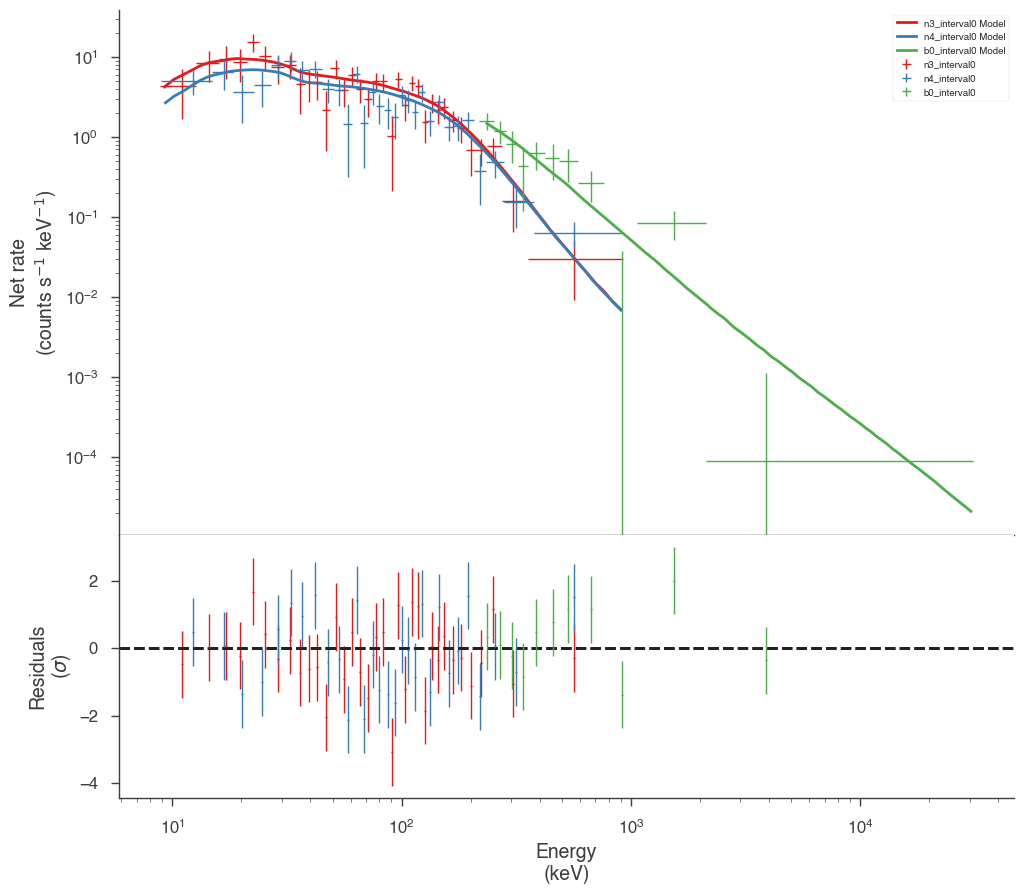

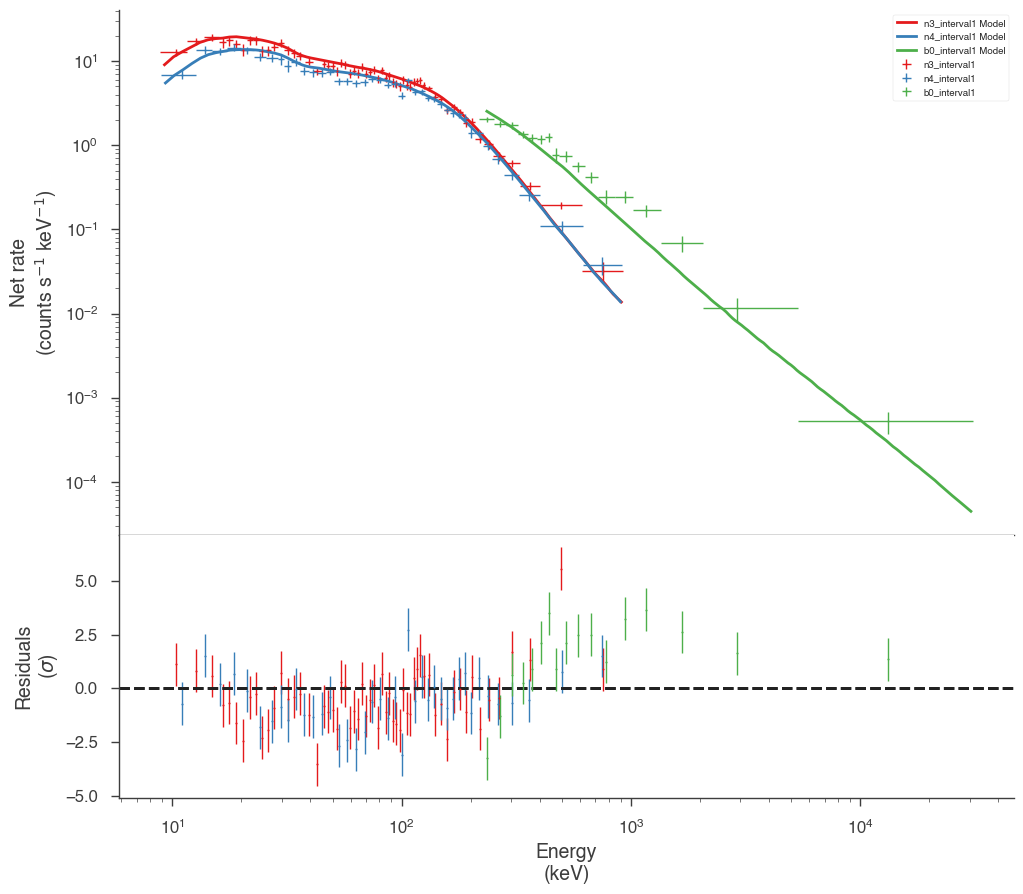

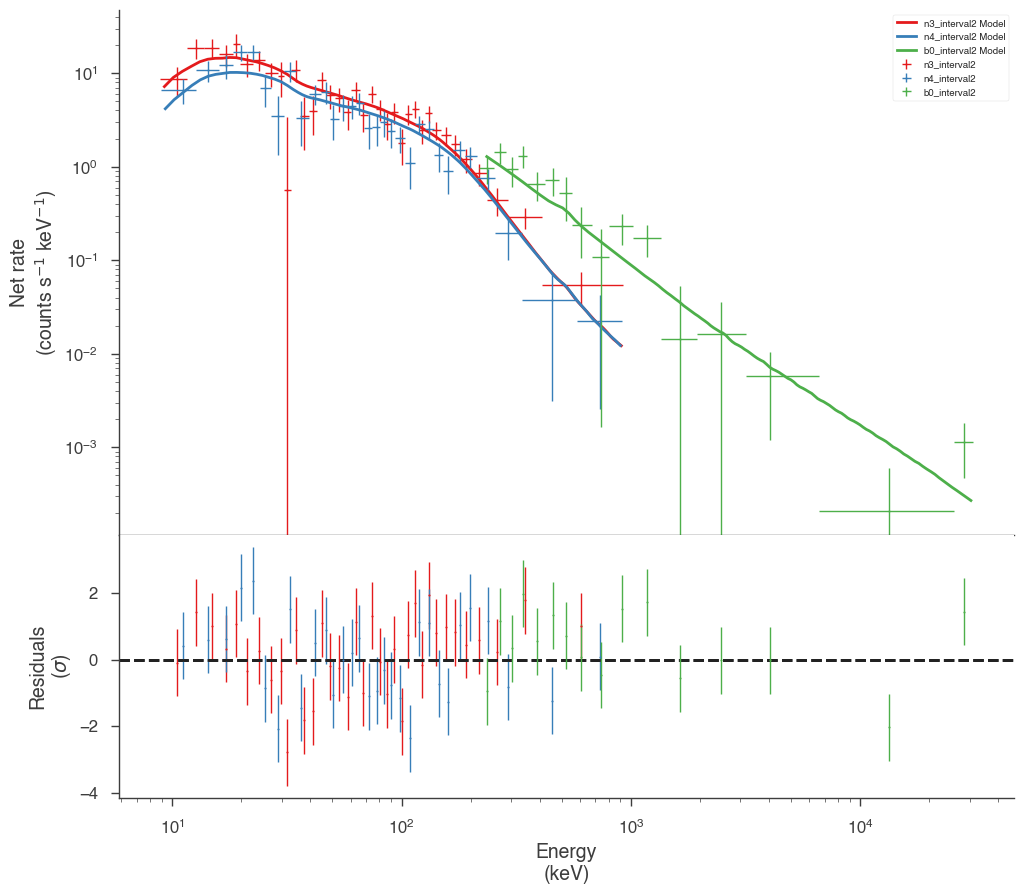

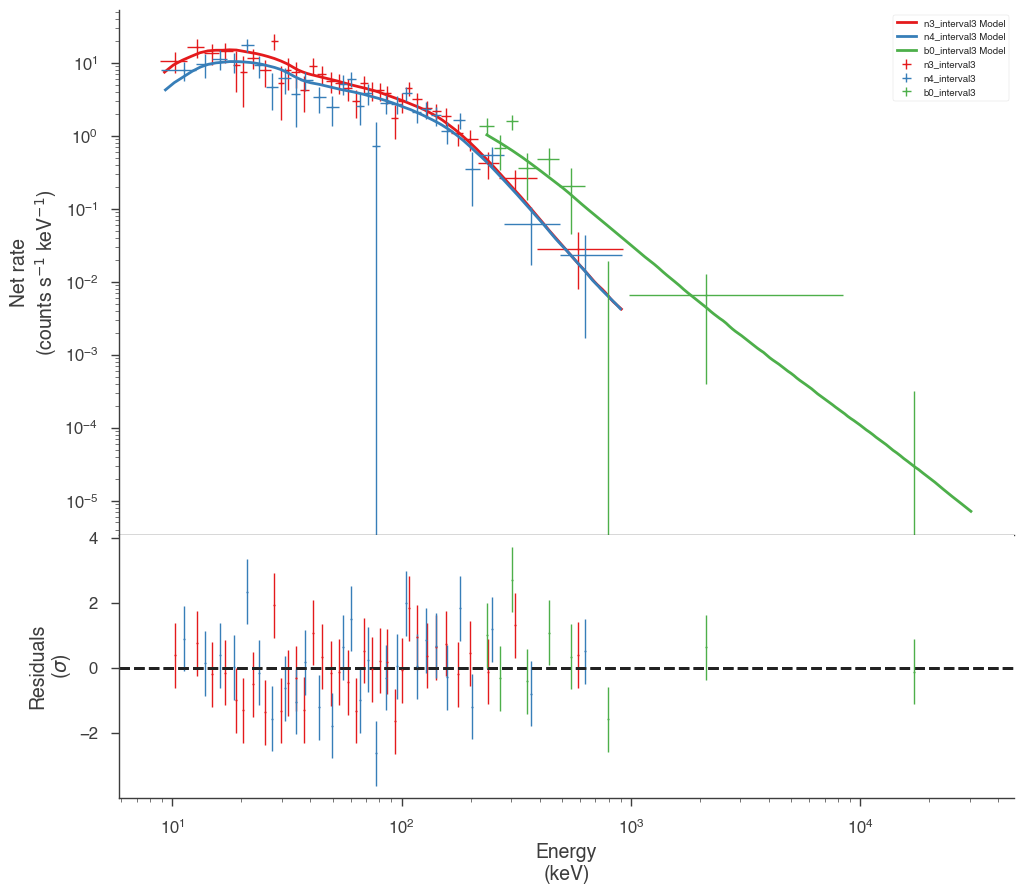

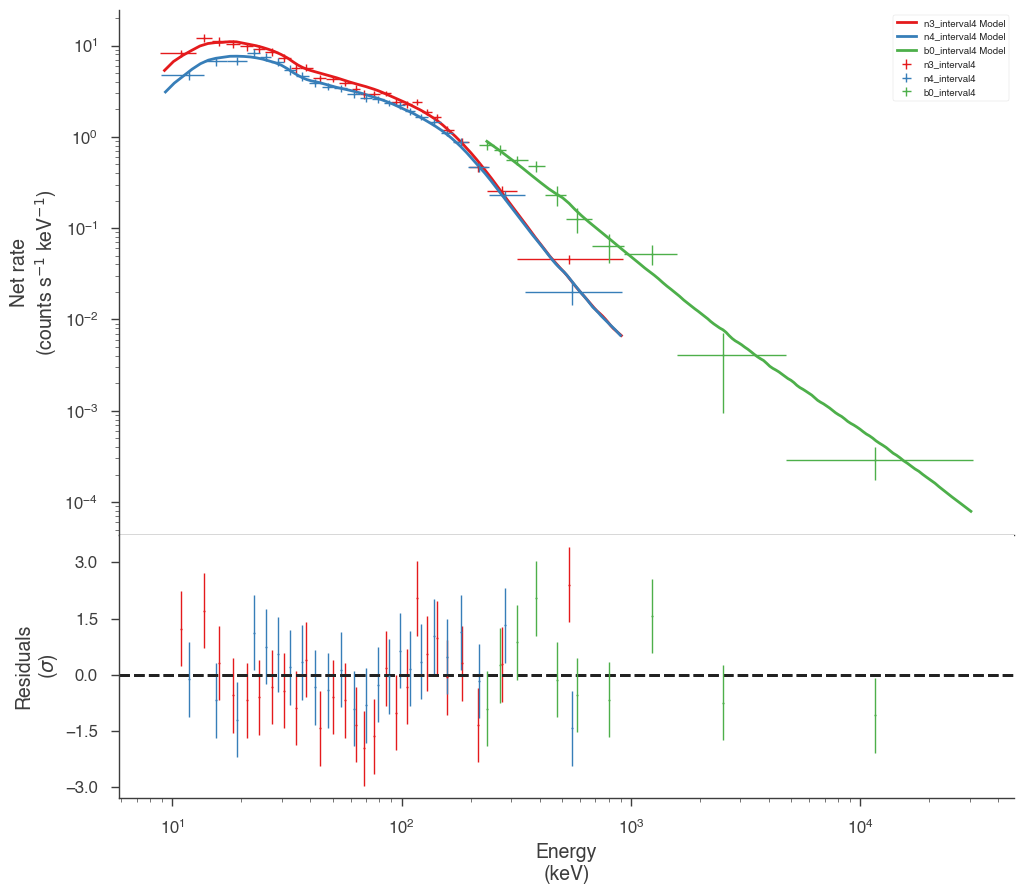

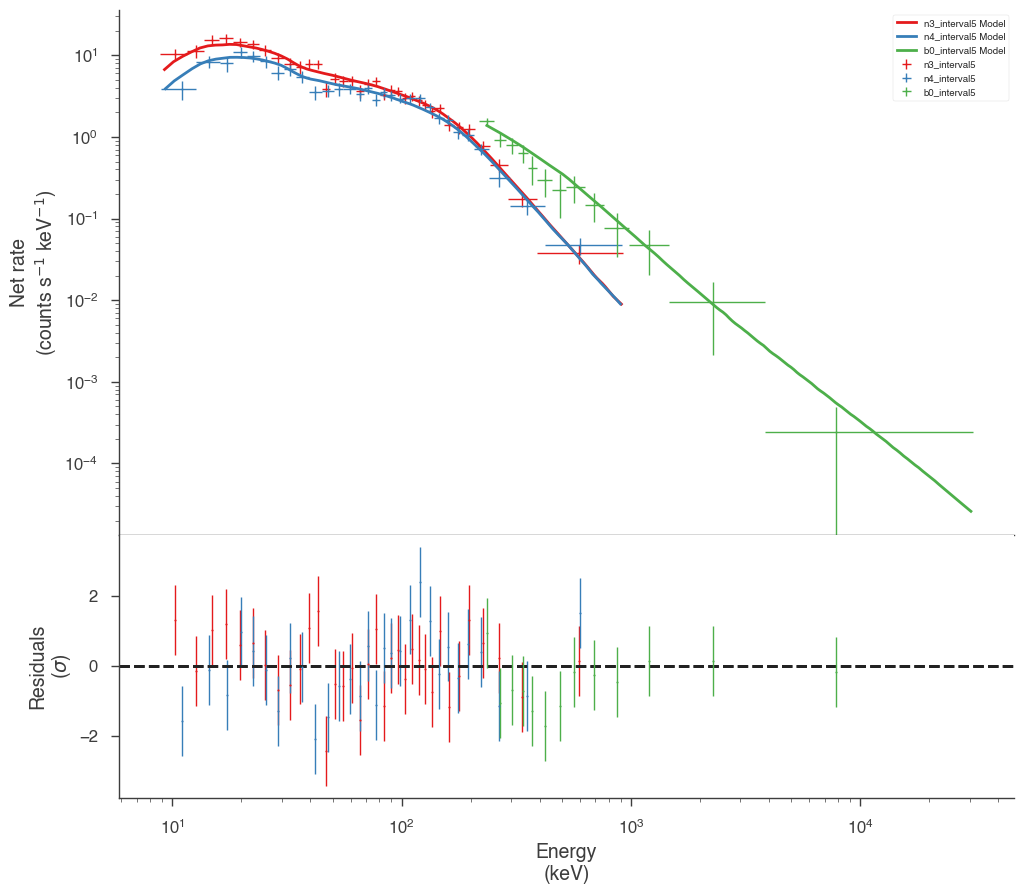

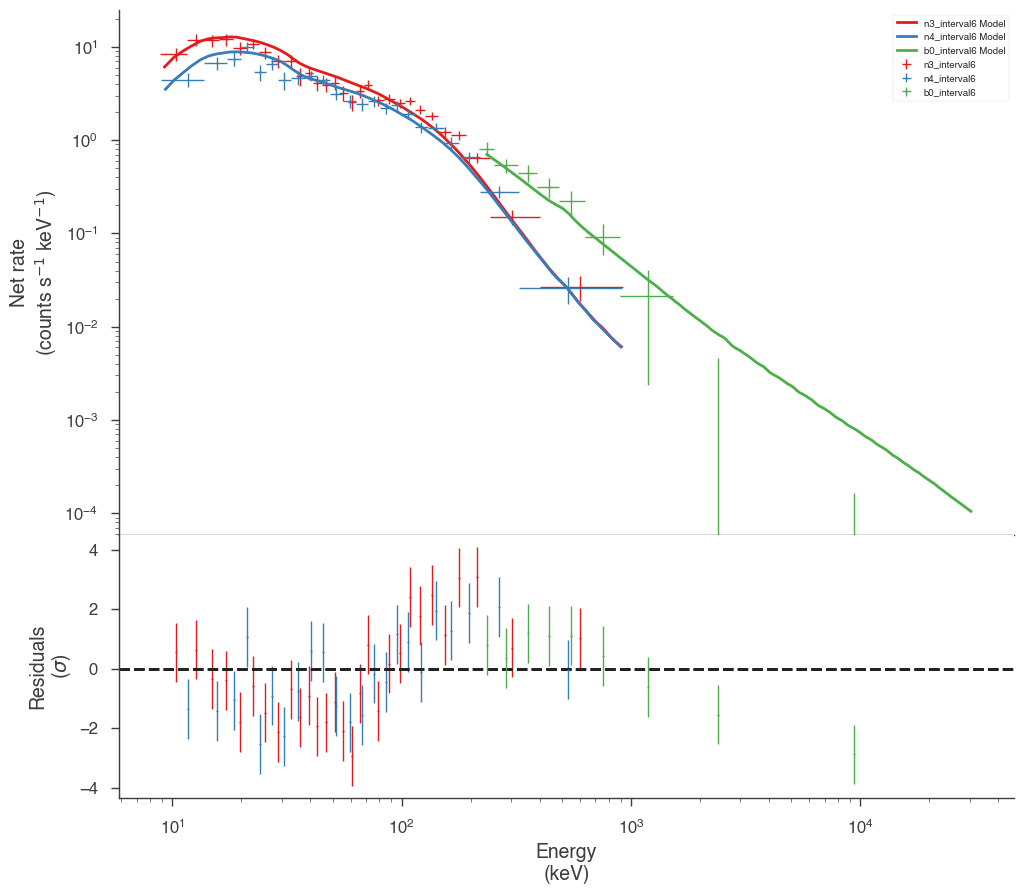

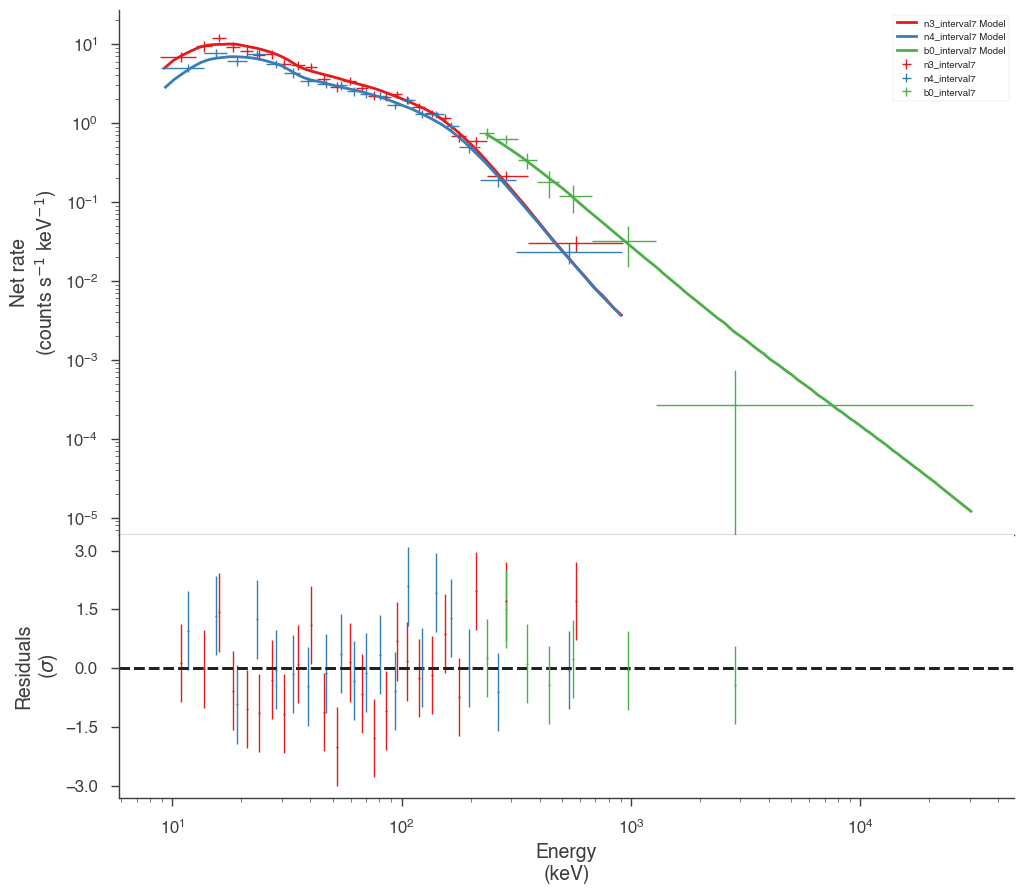

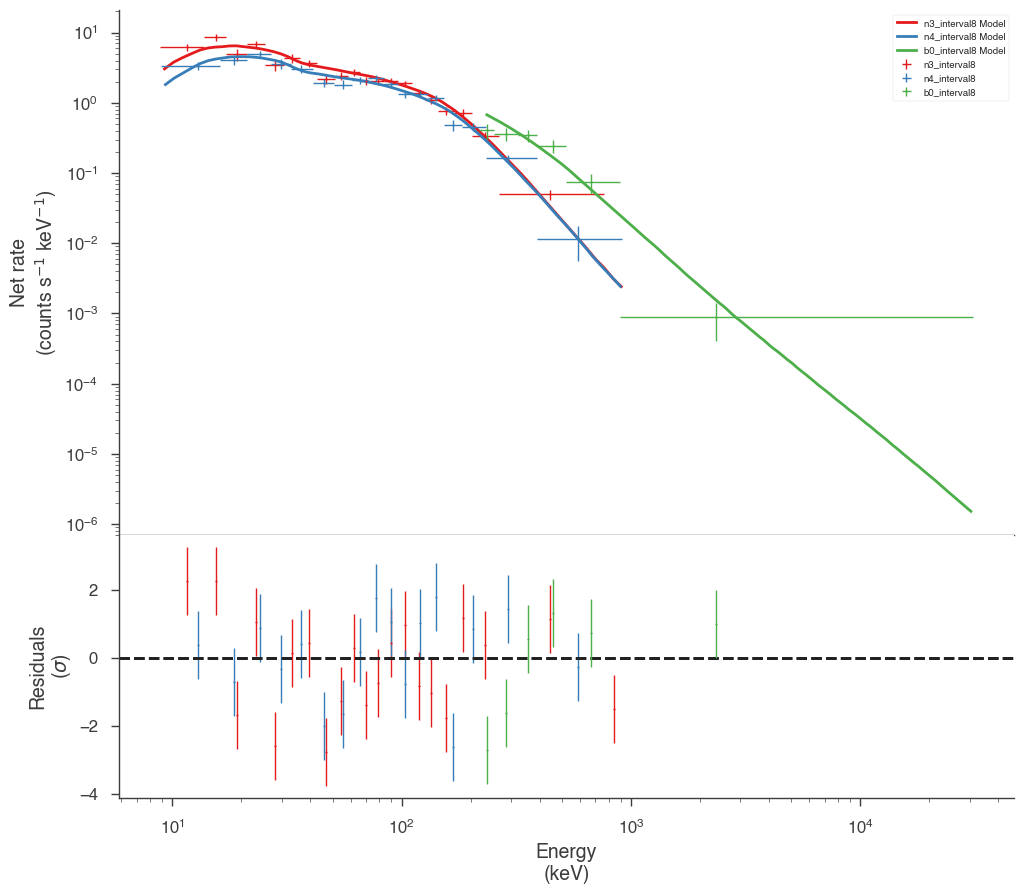

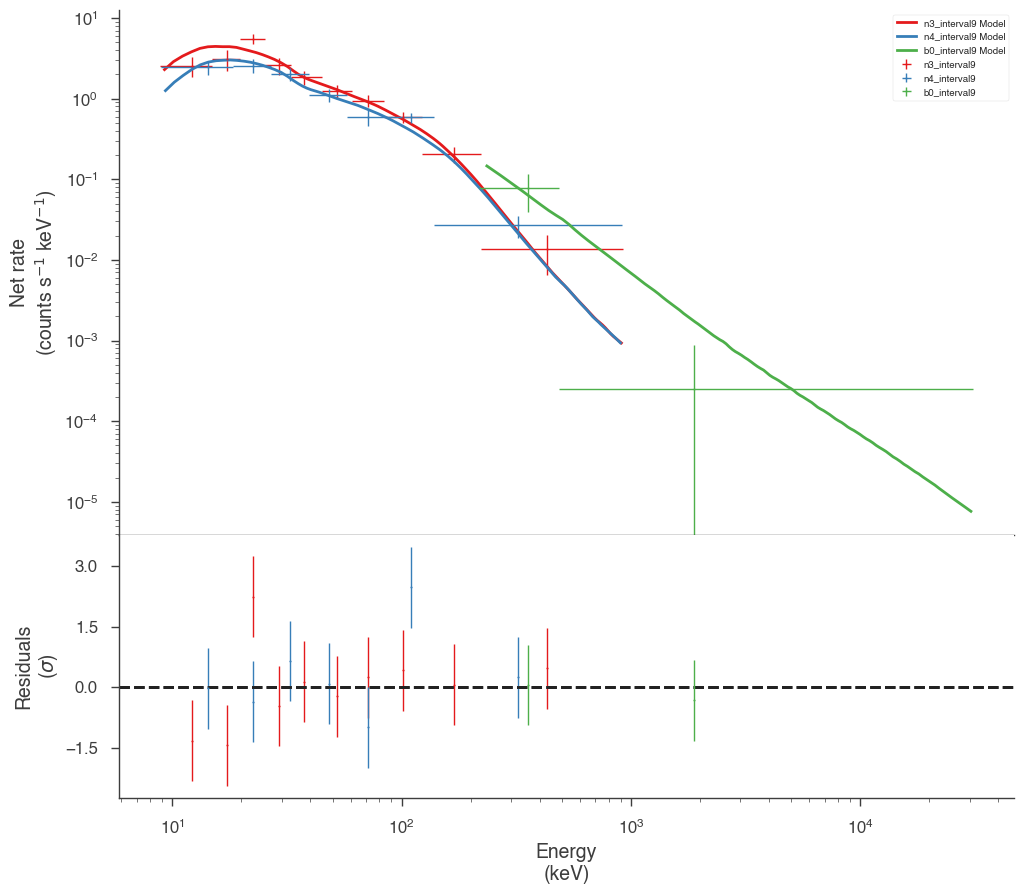

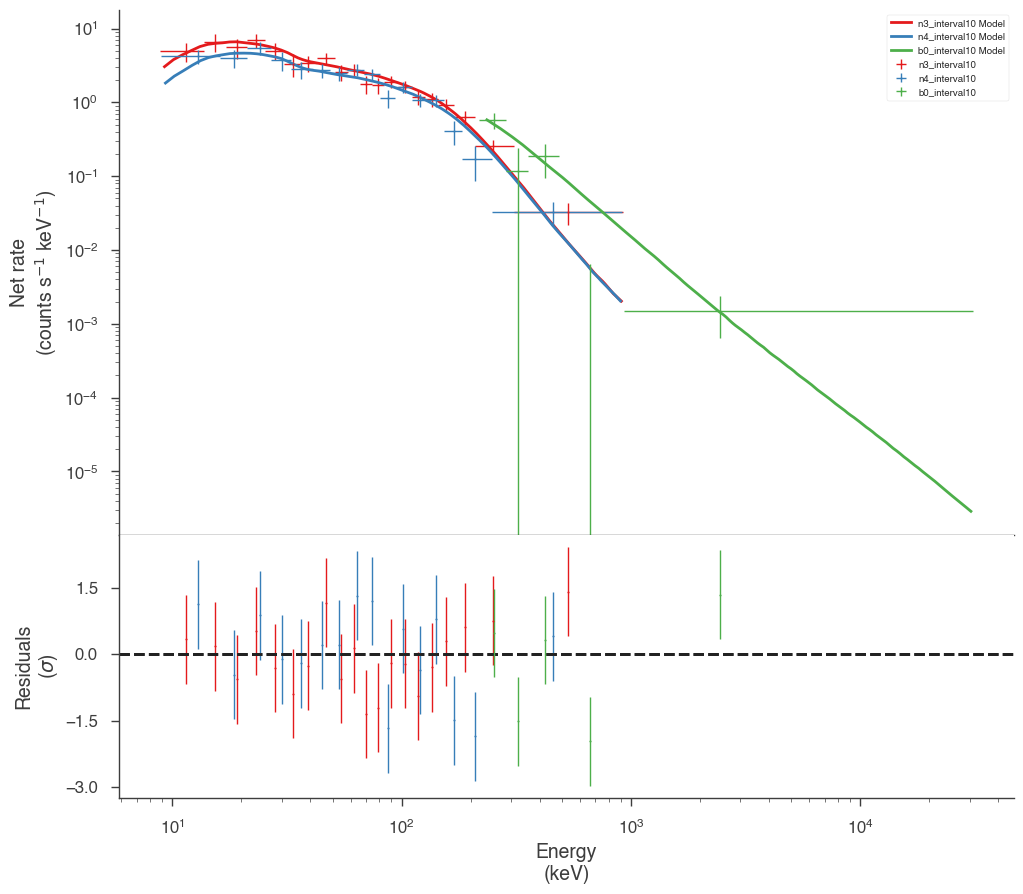

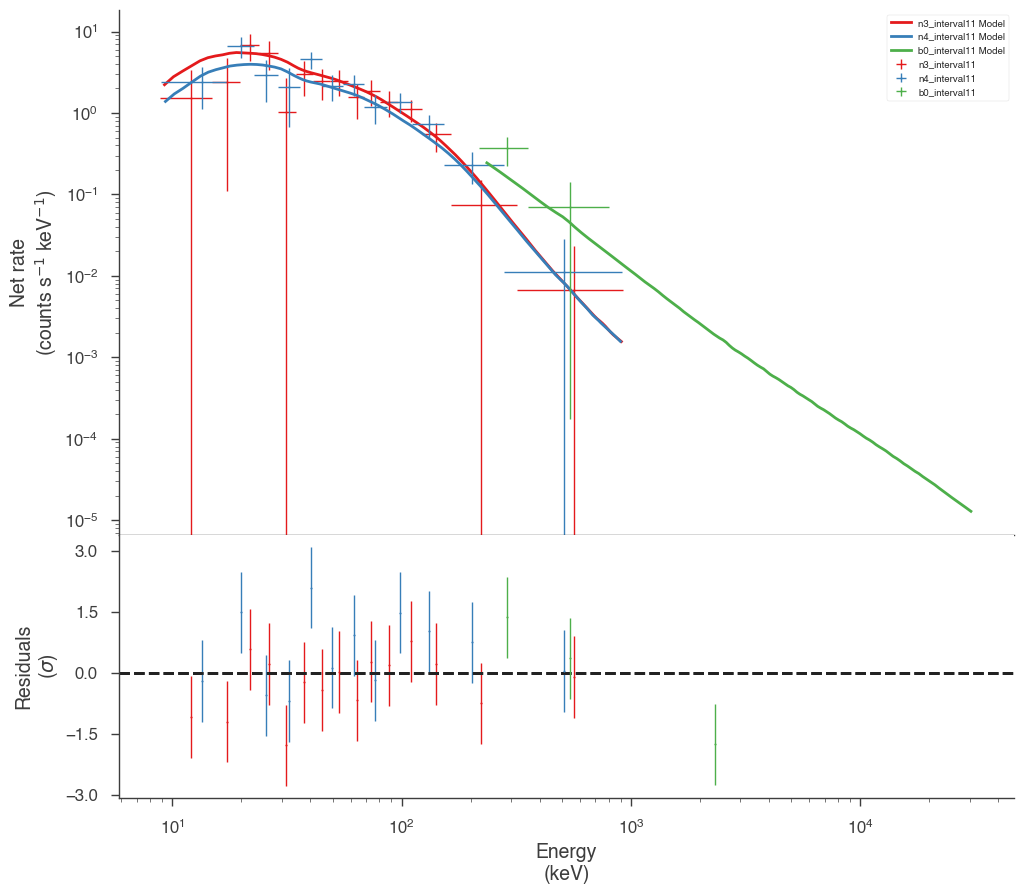

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

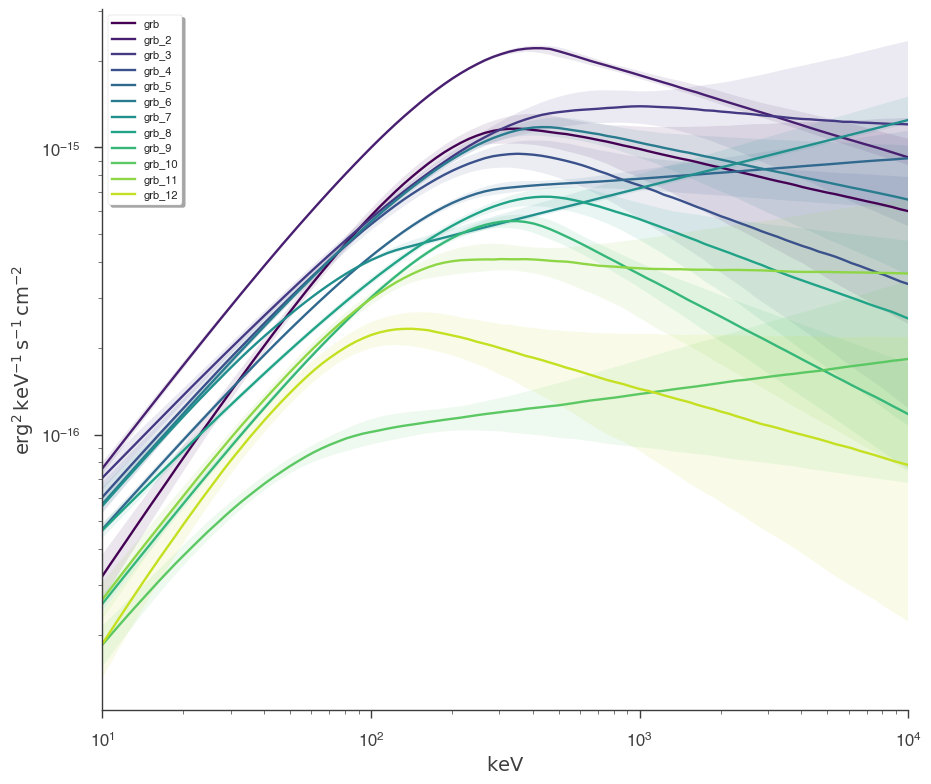

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.